In [1]:
## Imports
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile as wv
import torch
import torch.nn as nn
from tqdm import tqdm # progress bar
from audioMNIST import AudioMNIST
from DClassifier import CNN2DAudioClassifier
from torch.utils.data import DataLoader, random_split

In [2]:
file_paths = './data/'

In [3]:
if torch.cuda.is_available():
    print("Using CUDA device")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device('cpu')

Using CPU


In [ ]:
# Evaluation
def evaluate(model, val_dl): 
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
        
    for data in tqdm(val_dl):
        inputs, labels = data[0].to(device), data[1].to(device)

        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        optimizer.zero_grad()

        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))

        running_loss += loss.item()

        _, prediction = torch.max(outputs, 1)
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

    num_batches = len(val_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction / total_prediction

    return acc, avg_loss

In [ ]:
# Training
def training(model, train_dl, val_dl, num_epochs, 
             criterion, optimizer, scheduler):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        
        for data in tqdm(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            optimizer.zero_grad()
            
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()
            
            _, prediction = torch.max(outputs, 1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        
        v_acc, v_loss = evaluate(model.to(device), val_dl)
        
        print("Epoch: %d, Loss: %.4f, Train Accuracy: %.2f, Val. Loss: %.4f, Val. Accuracy: %.2f" % (
            epoch + 1, avg_loss, acc, v_loss, v_acc
        ))
        
        losses.append(avg_loss)
        val_losses.append(v_loss)
        
    return losses, val_losses

In [ ]:
if __name__ == '__main__':
    dataset = AudioMNIST()
    train_dl = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)
    model = CNN2DAudioClassifier().to(device)
    from torch.utils.data import random_split

    n_items = len(dataset)

    # items for train, validation, and test sets
    n_train = round(n_items * 0.7)
    n_val = round(n_items * 0.15)
     ## Ensures that rounding errors don't leave any data out
    n_test = n_items - n_train - n_val

    # split the dataset into training, validation, and test sets
    train_ds, val_test_ds = random_split(dataset, [n_train, n_items - n_train])
    val_ds, test_ds = random_split(val_test_ds, [n_val, n_test])

    # create DataLoaders
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
    val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
    test_dl = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)

In [16]:
dataset = AudioMNIST()
loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)

Total features loaded: 30000
Total labels loaded: 30000
Mean CV Accuracy for k=1: 0.9013666666666668
Mean CV Accuracy for k=2: 0.9013666666666668
Mean CV Accuracy for k=3: 0.9064
Mean CV Accuracy for k=4: 0.9108
Mean CV Accuracy for k=5: 0.9080999999999999
Mean CV Accuracy for k=6: 0.9109333333333334
Mean CV Accuracy for k=7: 0.9076666666666668
Mean CV Accuracy for k=8: 0.9099666666666668
Mean CV Accuracy for k=9: 0.9073
Mean CV Accuracy for k=10: 0.9081666666666667


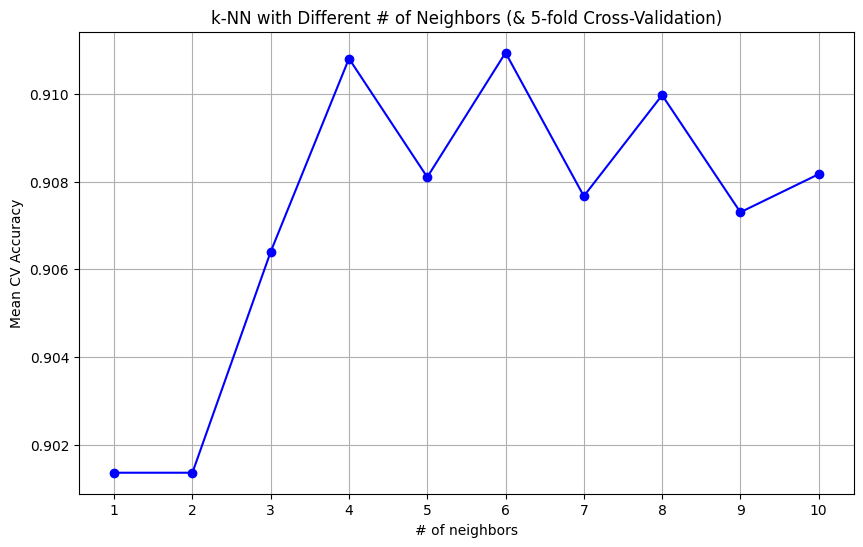

In [11]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Assuming the DataLoader and dataset are set up as above
dataset = AudioMNIST()  # Your dataset
loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=4)

# Load all data into memory
all_features = []
all_labels = []

for data, target in loader:
    all_features.append(data.numpy())
    all_labels.append(target.numpy())

# Flatten and reshape data
all_features = np.vstack(all_features).reshape(len(dataset), -1)
all_labels = np.concatenate(all_labels)

# Verify that all data points have been loaded
print(f"Total features loaded: {all_features.shape[0]}")
print(f"Total labels loaded: {all_labels.shape[0]}")

# Prepare to test different values of k
k_values = range(1, 11)  # k from 1 to 10
mean_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute', weights='distance')
    # Perform 20-fold cross-validation
    cv_scores = cross_val_score(knn, all_features, all_labels, cv=5)
    mean_accuracy = np.mean(cv_scores)
    mean_accuracies.append(mean_accuracy)
    print(f"Mean CV Accuracy for k={k}: {mean_accuracy}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_accuracies, marker='o', linestyle='-', color='b')
plt.title('k-NN with Different # of Neighbors (& 5-fold Cross-Validation)')
plt.xlabel('# of neighbors')
plt.ylabel('Mean CV Accuracy')
plt.grid(True)
plt.xticks(list(k_values))
plt.show()

In [ ]:
EPOCH_COUNT = 4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.001, 
                                                steps_per_epoch=int(len(train_dl)), 
                                                epochs=EPOCH_COUNT, 
                                                anneal_strategy='linear')

In [ ]:
losses, val_losses = training(model, train_dl, val_dl, EPOCH_COUNT, criterion, optimizer, scheduler)

In [ ]:
evaluate(model, val_dl)

In [ ]:
# Save model to use in Gradio App
#torch.save(model.state_dict(), 'audio_classifier_model.pth')